In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/countries-of-the-world/countries of the world.csv
/kaggle/input/cleaned-countriescsv/cleaned_countries.csv


# Understanding what predictors drive GDP through feature selection

In this notebook, we practice feature selection methods to help us identify and interpret factors that are most important in determining GDP. This is important when we want to understand insights between variables. This may also be important for downstream machine learning tasks, as it will help to 
* prevent overfitting 
* increase accuracy of model
* reducing the dimension of training data, lowering the computational time for model fitting
* more interpretable model

To achieve this, we will use a few methods 

## Traditional statistical methods (filter)
* Checking correlation with outcome 

Cons: best subset may not always be selected

## Wrapper methods 
* Recursive Feature Elimination (RFE)
* Forward/backward Elimination 

Pros: can select the best subset 

## Feature importance methods
* Random forests
* XGBoost 
* Extra trees

Pros: can select the best subset

## Embedded methods 
* Lasso
* ElasticNet 

Pros: can select the best subset

# Reading the data (and cleaning)

In [3]:
import os 
os.getcwd()
os.listdir("/kaggle/input/cleaned-countriescsv")

countries = pd.read_csv("/kaggle/input/cleaned-countriescsv/cleaned_countries.csv", index_col = 0)

In [4]:
## Basic check 
(countries.head())

,Country,Region,Population,Area,Pop._Density,Coastline,Net_migration,Infant_mortality,GDP,Literacy,...,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service,landlocked,cluster_labels
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,480,0,2306.0,16307.0,700.0,360.0,...,22.0,8765.0,1.0,466.0,2034.0,38.0,24.000000,38.000,1,2
1,Albania,EASTERN EUROPE,3581655,28748,1246,126,-493.0,2152.0,4500.0,865.0,...,442.0,7449.0,3.0,1511.0,522.0,232.0,188.000000,579.000,0,1
2,Algeria,NORTHERN AFRICA,32930091,2381740,138,4,-39.0,31.0,6000.0,700.0,...,25.0,9653.0,1.0,1714.0,461.0,101.0,6.000000,298.000,0,1
3,American Samoa,OCEANIA,57794,199,2904,5829,-2071.0,927.0,8000.0,970.0,...,15.0,75.0,2.0,2246.0,327.0,115.5,169.687500,473.375,0,1
4,Andorra,WESTERN EUROPE,71201,468,1521,0,66.0,405.0,19000.0,1000.0,...,0.0,9778.0,3.0,871.0,625.0,18.2,159.458333,492.625,1,3


Cluster labels are generated from a previous exercise where we used the existing columns to conduct clustering via KMeans. We will remove it as it is highly correlated with the information we already have 

In [5]:
countries = countries.drop(columns = 'cluster_labels')

In [6]:
## Check the strings 
print(countries.Country.head().to_list()) ## we see whitespace that needs to be cleaned
print(countries.Region.head().to_list())

['Afghanistan ', 'Albania ', 'Algeria ', 'American Samoa ', 'Andorra ']
['ASIA (EX. NEAR EAST)         ', 'EASTERN EUROPE                     ', 'NORTHERN AFRICA                    ', 'OCEANIA                            ', 'WESTERN EUROPE                     ']


In [7]:
## Remove whitespace via strip method -- use pandas string method 
countries.Country = countries.Country.str.strip()
countries.Region = countries.Region.str.strip()

In [8]:
## Check again
print(countries.Country.head().to_list())
print(countries.Region.head().to_list())

['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra']
['ASIA (EX. NEAR EAST)', 'EASTERN EUROPE', 'NORTHERN AFRICA', 'OCEANIA', 'WESTERN EUROPE']


In [9]:
## Check for missing data 
countries.isna().sum(axis = 0) ## check by columns

Country             0
Region              0
Population          0
Area                0
Pop._Density        0
Coastline           0
Net_migration       0
Infant_mortality    0
GDP                 0
Literacy            0
Phones              0
Arable              0
Crops               0
Other               0
Climate             0
Birthrate           0
Deathrate           0
Agriculture         0
Industry            0
Service             0
landlocked          0
dtype: int64

## List of predictors :

In [10]:
print(countries.columns)

Index(['Country', 'Region', 'Population', 'Area', 'Pop._Density', 'Coastline',
       'Net_migration', 'Infant_mortality', 'GDP', 'Literacy', 'Phones',
       'Arable', 'Crops', 'Other', 'Climate', 'Birthrate', 'Deathrate',
       'Agriculture', 'Industry', 'Service', 'landlocked'],
      dtype='object')


# Method 1 : filter methods 

First, we need to subset for the numeric columns (we have two non numeric columns, as we will see, that will prevent us from getting the correlation matrix)

In [11]:
## print data types of columns 
countries.dtypes

Country              object
Region               object
Population            int64
Area                  int64
Pop._Density          int64
Coastline             int64
Net_migration       float64
Infant_mortality    float64
GDP                 float64
Literacy            float64
Phones              float64
Arable              float64
Crops               float64
Other               float64
Climate             float64
Birthrate           float64
Deathrate           float64
Agriculture         float64
Industry            float64
Service             float64
landlocked            int64
dtype: object

In [12]:
## get the numeric subset 
numeric_subset = countries.select_dtypes(include = np.number)

## check 
#print(numeric_subset.head())
print(numeric_subset.columns)
print(numeric_subset.dtypes)

Index(['Population', 'Area', 'Pop._Density', 'Coastline', 'Net_migration',
       'Infant_mortality', 'GDP', 'Literacy', 'Phones', 'Arable', 'Crops',
       'Other', 'Climate', 'Birthrate', 'Deathrate', 'Agriculture', 'Industry',
       'Service', 'landlocked'],
      dtype='object')
Population            int64
Area                  int64
Pop._Density          int64
Coastline             int64
Net_migration       float64
Infant_mortality    float64
GDP                 float64
Literacy            float64
Phones              float64
Arable              float64
Crops               float64
Other               float64
Climate             float64
Birthrate           float64
Deathrate           float64
Agriculture         float64
Industry            float64
Service             float64
landlocked            int64
dtype: object


In [13]:
## get correlation matrix
corr_mat = numeric_subset.corr()
print(corr_mat.shape) ## we have 20 numeric columns, hence 20 by 20

(corr_mat)

(19, 19)


,Population,Area,Pop._Density,Coastline,Net_migration,Infant_mortality,GDP,Literacy,Phones,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service,landlocked
Population,1.000000,0.469985,-0.028190,-0.068199,0.002400,0.008984,-0.038853,-0.049303,-0.029876,0.015950,-0.051831,0.016175,0.438492,-0.036125,0.004104,0.058936,0.127757,0.051057,-0.072023
Area,0.469985,1.000000,-0.066917,-0.095627,0.046762,-0.017336,0.072497,0.029462,0.054151,-0.085866,-0.132251,0.156976,0.141590,-0.053244,0.031268,-0.022625,0.112232,0.034677,-0.043623
Pop._Density,-0.028190,-0.066917,1.000000,0.241690,0.177022,-0.130429,0.196099,0.097432,0.280596,-0.067870,-0.025788,-0.232562,-0.025110,-0.132340,-0.041433,-0.133392,-0.076394,0.150069,-0.083004
Coastline,-0.068199,-0.095627,0.241690,1.000000,-0.140475,-0.113211,0.049625,0.127801,0.153218,-0.125827,0.344830,-0.188772,-0.067091,-0.048433,-0.159670,-0.030266,-0.160590,0.069866,-0.143888
Net_migration,0.002400,0.046762,0.177022,-0.140475,1.000000,-0.030724,0.372902,-0.007832,0.223897,-0.074251,-0.259614,0.114011,-0.042607,-0.113367,0.007040,-0.180765,-0.002290,-0.031795,0.072609
Infant_mortality,0.008984,-0.017336,-0.130429,-0.113211,-0.030724,1.000000,-0.529505,-0.651334,-0.592903,-0.095532,-0.010983,0.097663,0.049857,0.603431,0.429622,0.455022,0.003794,-0.288471,0.314554
GDP,-0.038853,0.072497,0.196099,0.049625,0.372902,-0.529505,1.000000,0.515455,0.830684,0.010294,-0.199994,0.014097,-0.074974,-0.542198,-0.179251,-0.497899,-0.031154,0.272964,-0.112829
Literacy,-0.049303,0.029462,0.097432,0.127801,-0.007832,-0.651334,0.515455,1.000000,0.590145,0.063891,0.036170,-0.149936,0.049828,-0.689543,-0.243263,-0.388064,0.022773,0.268385,-0.107589
Phones,-0.029876,0.054151,0.280596,0.153218,0.223897,-0.592903,0.830684,0.590145,1.000000,0.022157,-0.142818,-0.163735,-0.078948,-0.616967,-0.181406,-0.522373,-0.145685,0.239443,-0.179461
Arable,0.015950,-0.085866,-0.067870,-0.125827,-0.074251,-0.095532,0.010294,0.063891,0.022157,1.000000,0.097510,-0.152397,-0.005169,-0.144330,0.129845,0.073268,0.046574,0.110910,0.038633


In [14]:
## Corr btn GDP and the rest
gdp_corr = corr_mat['GDP'].drop('GDP')
print(gdp_corr.sort_values())

## See summary
gdp_corr.describe()

Birthrate          -0.542198
Infant_mortality   -0.529505
Agriculture        -0.497899
Crops              -0.199994
Deathrate          -0.179251
landlocked         -0.112829
Climate            -0.074974
Population         -0.038853
Industry           -0.031154
Arable              0.010294
Other               0.014097
Coastline           0.049625
Area                0.072497
Pop._Density        0.196099
Service             0.272964
Net_migration       0.372902
Literacy            0.515455
Phones              0.830684
Name: GDP, dtype: float64


count    18.000000
mean      0.007109
std       0.353976
min      -0.542198
25%      -0.162645
50%      -0.010430
75%       0.165198
max       0.830684
Name: GDP, dtype: float64

In this case, since we are just looking for relevance in the form of the magnitude of correlation coefficient, we can just look at the absolute values

In [15]:
gdp_corr_abs = np.abs(gdp_corr)

## print sorted
gdp_corr_abs.sort_values(ascending = False)

Phones              0.830684
Birthrate           0.542198
Infant_mortality    0.529505
Literacy            0.515455
Agriculture         0.497899
Net_migration       0.372902
Service             0.272964
Crops               0.199994
Pop._Density        0.196099
Deathrate           0.179251
landlocked          0.112829
Climate             0.074974
Area                0.072497
Coastline           0.049625
Population          0.038853
Industry            0.031154
Other               0.014097
Arable              0.010294
Name: GDP, dtype: float64

Let us choose a value of 0.2 as the threshold, to separate out the 'weak' correlation with the 'strong' ones. This is however very subjective and is by no means rigorous or robust. 

### threshold for correlation coefficient: 0.2

In [16]:
(gdp_corr_abs > 0.2).sort_values(ascending = False)

Service              True
Net_migration        True
Infant_mortality     True
Literacy             True
Phones               True
Agriculture          True
Birthrate            True
Population          False
Climate             False
Industry            False
Deathrate           False
Crops               False
Other               False
Area                False
Arable              False
Coastline           False
Pop._Density        False
landlocked          False
Name: GDP, dtype: bool

Here, we see that only birthrate, agriculture, phones, literacy, infant mortality rate, net migration and service exceed the threshold. Population, climate, industry, deathrate... do not strongly correlate with GDP. 

In [17]:
subset1 = gdp_corr_abs[gdp_corr_abs > 0.2].index.to_list()
print(subset1)

['Net_migration', 'Infant_mortality', 'Literacy', 'Phones', 'Birthrate', 'Agriculture', 'Service']


## Categorical column: Region

What about the correlation between GDP and region (categorical)? For this case (continuous outcome, categorical predictor), we use **ANOVA** to test the correlation.

ANOVA assumes the following:
* Population distributions are normal
* Samples have equal variances 
* Independence of observations 

ANOVA tests the null hypothesis $H_0$ that: 

$$H_0: \mu_1 = \mu_2 = ... = \mu_n  $$

for n groups of observations

In [18]:
print(countries.groupby('Region')['GDP'].mean())
print(countries.groupby('Region')['GDP'].std())

Region
ASIA (EX. NEAR EAST)     8053.571429
BALTICS                 11300.000000
C.W. OF IND. STATES      4000.000000
EASTERN EUROPE           9808.333333
LATIN AMER. & CARIB      8682.222222
NEAR EAST               10456.250000
NORTHERN AFRICA          5460.000000
NORTHERN AMERICA        26100.000000
OCEANIA                  8247.619048
SUB-SAHARAN AFRICA       2323.529412
WESTERN EUROPE          27046.428571
Name: GDP, dtype: float64
Region
ASIA (EX. NEAR EAST)     9166.787156
BALTICS                  1053.565375
C.W. OF IND. STATES      2461.706725
EASTERN EUROPE           4978.765516
LATIN AMER. & CARIB      6658.463134
NEAR EAST                8447.876952
NORTHERN AFRICA          1225.724276
NORTHERN AMERICA        12791.012470
OCEANIA                  8095.221989
SUB-SAHARAN AFRICA       2614.084026
WESTERN EUROPE           7618.859745
Name: GDP, dtype: float64


In [19]:
import scipy.stats as stats

regions_unique = countries.Region.unique()
GDP_by_region = [countries[countries.Region == region]['GDP'] for region in regions_unique]

## check
print(len(GDP_by_region))

## Conduct one way ANOVA
stats.f_oneway(*GDP_by_region)

11


F_onewayResult(statistic=30.030928044739134, pvalue=9.773566950546968e-36)

The p value is essentially 0, giving us evidence to reject the null hypothesis that the means of GDP are equal. 



In [20]:
## in this case, * functions as a splat operator and unpacks lists
## or tuples
print(*[[1,2,3]])
print(*[1,2,3])

[1, 2, 3]
1 2 3


### Visualisation

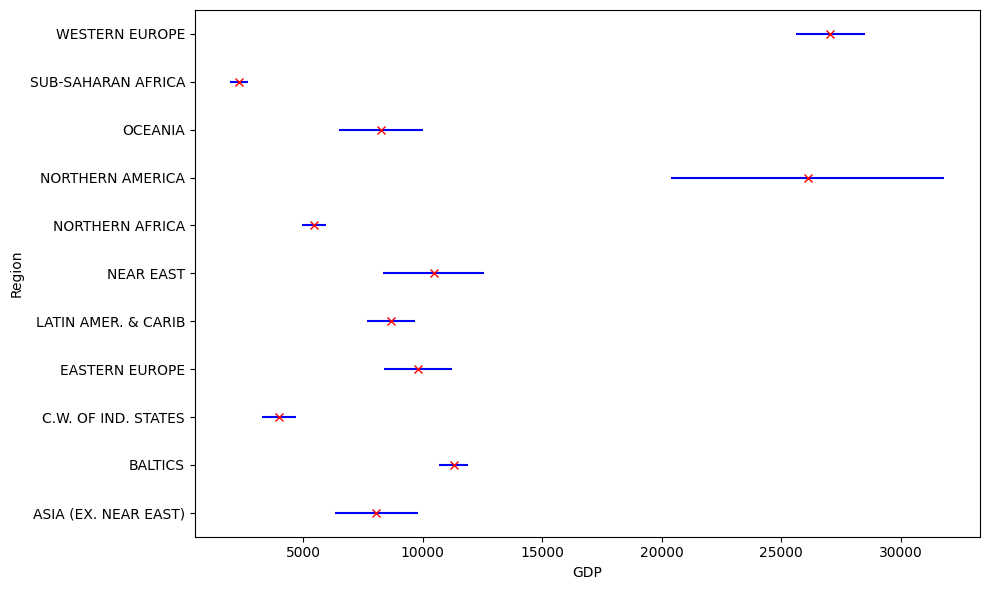

In [21]:
import matplotlib.pyplot as plt

## Calculate means and standard errors for each region
means = countries.groupby('Region')['GDP'].mean()
ses = countries.groupby('Region')['GDP'].sem()

## Set up the figure size and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot horizontal lines for means 
for i, region in enumerate(means.index): ## enumerate as we need i to 
    ## specify which subplot/axis
    mean = means[region]
    se = ses[region]
    
    ## Plot standard error
    ax.hlines(y=i, xmin=mean - se, xmax=mean + se, color='blue')
    
    ## Plot mean
    ax.plot(mean, i, 'rx')
    
## manually set tick markers and tick labels for y axis
ax.set_yticks(range(len(means)))
ax.set_yticklabels(means.index)

## Label the axes
ax.set_xlabel('GDP')
ax.set_ylabel('Region')

## Show the plot
plt.tight_layout()
plt.show()


We see strong evidence that the region means differ widely, but we also see that the standard errors (estimators for variance by region) are very different, discrediting our use of the ANOVA. 

In [22]:
wide_format_GDP_region = countries[['GDP', 'Region']].pivot(columns = 'Region', values = 'GDP')

print((wide_format_GDP_region.head()))

Region  ASIA (EX. NEAR EAST)  BALTICS  C.W. OF IND. STATES  EASTERN EUROPE  \
0                      700.0      NaN                  NaN             NaN   
1                        NaN      NaN                  NaN          4500.0   
2                        NaN      NaN                  NaN             NaN   
3                        NaN      NaN                  NaN             NaN   
4                        NaN      NaN                  NaN             NaN   

Region  LATIN AMER. & CARIB  NEAR EAST  NORTHERN AFRICA  NORTHERN AMERICA  \
0                       NaN        NaN              NaN               NaN   
1                       NaN        NaN              NaN               NaN   
2                       NaN        NaN           6000.0               NaN   
3                       NaN        NaN              NaN               NaN   
4                       NaN        NaN              NaN               NaN   

Region  OCEANIA  SUB-SAHARAN AFRICA  WESTERN EUROPE  
0           Na

<Axes: ylabel='Density'>

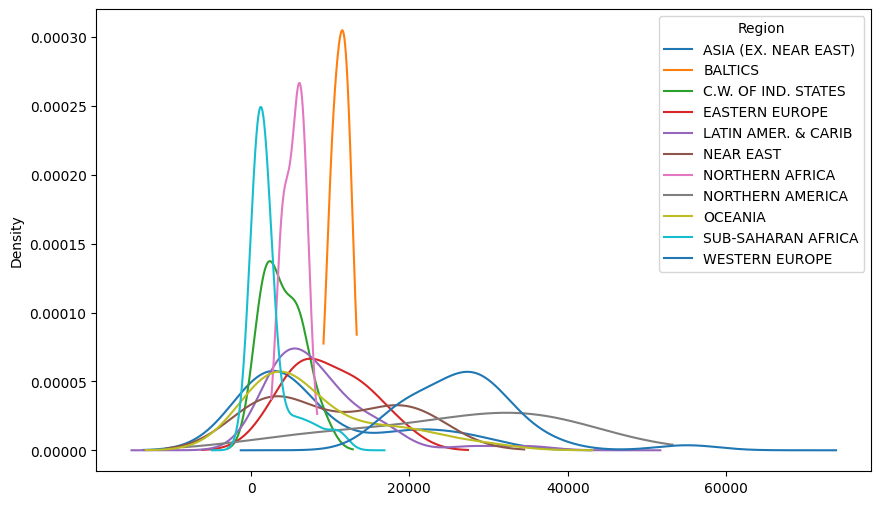

In [23]:
wide_format_GDP_region.plot.density(figsize = (10,6))

The normality assumption may be violated as well - for instance, Near East has a bimodal distribution for GDP

Text(0.5, 1.0, 'Near East GDP Distribution')

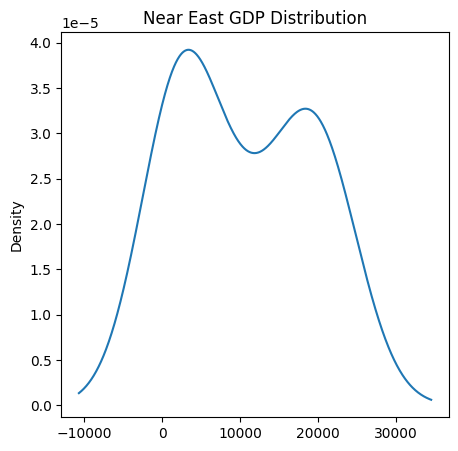

In [24]:
wide_format_GDP_region['NEAR EAST'].plot.density(figsize = (5,5))
plt.title('Near East GDP Distribution')

# Method 2: Wrapper methods

We still have to decied what model we would like to use under the wrapper. We will opt for a linear model in this case.

## 2.1: Foward selection

In [25]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

For modelling, we need to first preprocess our data and make sure it is ready to be fitted into models 

In [26]:
## Drop country names and landlocked, as we already have coastline feature
countries = countries.drop(columns = ['Country', 'landlocked'])

### Preprocessing: Standardising data

In [27]:
## Get numeric only first 
numeric_only = countries.select_dtypes(include = np.number)
categorical_only = countries.select_dtypes(include = object)

## check
print(numeric_only.dtypes)
print(categorical_only.dtypes)

## Standardise numeric
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_standardised = scaler.fit_transform(numeric_only)

Population            int64
Area                  int64
Pop._Density          int64
Coastline             int64
Net_migration       float64
Infant_mortality    float64
GDP                 float64
Literacy            float64
Phones              float64
Arable              float64
Crops               float64
Other               float64
Climate             float64
Birthrate           float64
Deathrate           float64
Agriculture         float64
Industry            float64
Service             float64
dtype: object
Region    object
dtype: object


In [28]:
## Check result of standardising 
print(numeric_only.mean())

print('\n\n ============ STANDARDISING ==========\n\n')
print(pd.DataFrame(numeric_standardised, columns = numeric_only.columns).mean())

numeric_standardised = pd.DataFrame(numeric_standardised, columns = numeric_only.columns)

Population          2.874028e+07
Area                5.982270e+05
Pop._Density        3.790471e+03
Coastline           2.116533e+03
Net_migration       1.045170e+01
Infant_mortality    3.149682e+03
GDP                 9.671189e+03
Literacy            8.338750e+02
Phones              2.352151e+03
Arable              1.163067e+03
Crops               4.124124e+02
Other               6.811860e+03
Climate             2.995597e+00
Birthrate           2.038440e+03
Deathrate           8.157324e+02
Agriculture         1.059327e+02
Industry            2.170403e+02
Service             4.121566e+02
dtype: float64


 ============ STANDARDISING ==========


Population         -7.825361e-18
Area                3.912680e-17
Pop._Density       -1.956340e-17
Coastline           2.347608e-17
Net_migration      -3.912680e-18
Infant_mortality   -2.347608e-17
GDP                 7.825361e-17
Literacy            2.660623e-16
Phones              1.017297e-16
Arable              1.936777e-16
Crops             

### Preprocessing: One hot encoding 

In [29]:
## Recombine data 
countries_standardised = pd.concat([numeric_standardised, categorical_only], axis = 1)


In [30]:
## One hot encoding 
countries_preprocessed = pd.get_dummies(countries, columns = ['Region'])

## Checks
print(countries_preprocessed.shape) ## 10 MORE COLUMNS SINCE WE HAVE 11 REGIONS AND MINUS ONE FOR NO PERFECT MULTICOLLINEARITY
print(countries_standardised.shape) 

(227, 29)
(227, 19)


In [31]:
## INSTANTIATE forward selection algo from mlxtend
forward_selection = SequentialFeatureSelector(LinearRegression(),
                          k_features = 'best', 
                          forward = True, ## floating -- whether to perform bidirectional search
                          scoring = 'r2')

## Get X and Y data ready 
X = countries_preprocessed.drop(columns = 'GDP')
y = countries_preprocessed['GDP']

## fit to data 
forward_selection_fitted = forward_selection.fit(X, y)

In [32]:
## check results
print(forward_selection_fitted.k_feature_names_)

subset2 = forward_selection_fitted.k_feature_names_

('Area', 'Net_migration', 'Literacy', 'Phones', 'Crops', 'Other', 'Deathrate', 'Agriculture', 'Industry', 'Service', 'Region_C.W. OF IND. STATES', 'Region_EASTERN EUROPE', 'Region_LATIN AMER. & CARIB', 'Region_WESTERN EUROPE')


In [33]:
## get params 
print(forward_selection_fitted.get_params())

{'clone_estimator': True, 'cv': 5, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__n_jobs': None, 'estimator__positive': False, 'estimator': LinearRegression(), 'feature_groups': None, 'fixed_features': None, 'floating': False, 'forward': True, 'k_features': (1, 28), 'n_jobs': 1, 'pre_dispatch': '2*n_jobs', 'scoring': 'r2', 'verbose': 0, 'linearregression': LinearRegression(), 'linearregression__copy_X': True, 'linearregression__fit_intercept': True, 'linearregression__n_jobs': None, 'linearregression__positive': False}


### Change scoring method to MSE

In [34]:
forward_selection_mse = SequentialFeatureSelector(LinearRegression(),
                          k_features = 'best', 
                          forward = True, ## floating -- whether to perform bidirectional search
                          scoring = 'neg_mean_squared_error')

forward_selection_mse_fitted = forward_selection_mse.fit(X, y)

print(forward_selection_mse_fitted.k_feature_names_)

subset3 = forward_selection_mse_fitted.k_feature_names_

('Area', 'Net_migration', 'Literacy', 'Phones', 'Crops', 'Other', 'Deathrate', 'Agriculture', 'Industry', 'Service', 'Region_C.W. OF IND. STATES', 'Region_EASTERN EUROPE', 'Region_LATIN AMER. & CARIB', 'Region_WESTERN EUROPE')


## Difference between scoring methods for forward selection?

In [35]:
print(subset2)
print(len(subset2))

print(' ======================= ')
print(subset3)
print(len(subset3))

print(' ======================= ')
print('Intersection')
print(set(subset2).intersection(set(subset3)))
print(len(set(subset2).intersection(set(subset3))))

('Area', 'Net_migration', 'Literacy', 'Phones', 'Crops', 'Other', 'Deathrate', 'Agriculture', 'Industry', 'Service', 'Region_C.W. OF IND. STATES', 'Region_EASTERN EUROPE', 'Region_LATIN AMER. & CARIB', 'Region_WESTERN EUROPE')
14
('Area', 'Net_migration', 'Literacy', 'Phones', 'Crops', 'Other', 'Deathrate', 'Agriculture', 'Industry', 'Service', 'Region_C.W. OF IND. STATES', 'Region_EASTERN EUROPE', 'Region_LATIN AMER. & CARIB', 'Region_WESTERN EUROPE')
14
Intersection
{'Deathrate', 'Agriculture', 'Industry', 'Literacy', 'Area', 'Service', 'Net_migration', 'Other', 'Crops', 'Region_EASTERN EUROPE', 'Phones', 'Region_C.W. OF IND. STATES', 'Region_WESTERN EUROPE', 'Region_LATIN AMER. & CARIB'}
14


The different scoring methods do not give different subsets

In [36]:
import sklearn.metrics
sklearn.metrics.get_scorer_names()[0:10]

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro']

## 2.2: Backward Selection

In [37]:
sfs_backward = SequentialFeatureSelector(LinearRegression(),
           k_features='best',
           forward=False,
           scoring='neg_mean_squared_error')

sfs_backward = sfs_backward.fit(X, y)
print('Selected features:', sfs_backward.k_feature_names_)
subset4 = sfs_backward.k_feature_names_

Selected features: ('Net_migration', 'Literacy', 'Phones', 'Crops', 'Other', 'Agriculture', 'Industry', 'Region_BALTICS', 'Region_C.W. OF IND. STATES', 'Region_EASTERN EUROPE', 'Region_LATIN AMER. & CARIB', 'Region_WESTERN EUROPE')


In [38]:
print(len(subset4))

12


## 2.3: Bidirectional Elimination

In [39]:
sfs_bidirectional = SequentialFeatureSelector(LinearRegression(),
           k_features='best',
           forward=True,
           floating=True,
           scoring='neg_mean_squared_error')

sfs_bidirectional = sfs_bidirectional.fit(X, y)
print('Selected features:', sfs_bidirectional.k_feature_names_)
subset5 = sfs_bidirectional.k_feature_names_

Selected features: ('Area', 'Net_migration', 'Literacy', 'Phones', 'Crops', 'Other', 'Deathrate', 'Agriculture', 'Service', 'Region_C.W. OF IND. STATES', 'Region_EASTERN EUROPE', 'Region_LATIN AMER. & CARIB', 'Region_WESTERN EUROPE')


In [40]:
print(len(subset5))

13


# Method 3: Feature Importance 

## Random forests, xgboost

For the third method, we will fit the data using tree-based methods, and then take the feature importance metrics.

There are two types of feature importance 

* Impurity based feature importance: *accumulation of impurity decrease within each tree * (sklearn documentation)
* Permuation based feature importance: *overcomes limitatins of impurtiy based feature importance since they do not have a bias towards high-cardinaity features and can be computed on left out test set*

In [41]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor ## GDP is continuous -- reg problem
from sklearn.feature_selection import SelectFromModel

In [42]:
rf = RandomForestRegressor() ## use default hyperparameters
rf.fit(X,y)

RandomForestRegressor()

In [43]:
rf_results_df = pd.DataFrame({

    'preds': rf.feature_names_in_, 
    'feature_importance_impurity': rf.feature_importances_})

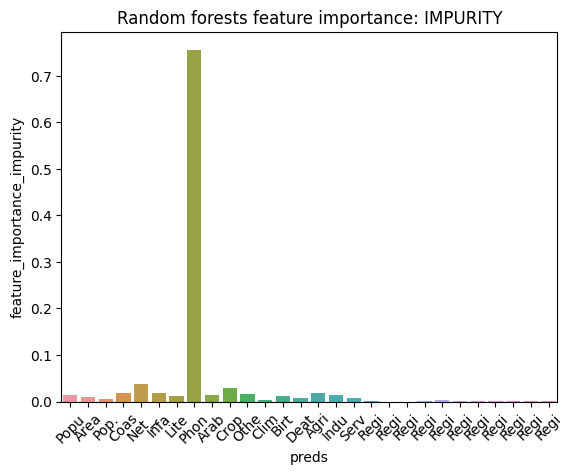

In [44]:
import seaborn as sns
g = sns.barplot(rf_results_df, x = 'preds', y = 'feature_importance_impurity')
g.set_xticks(range(len(rf_results_df)))
g.set_xticklabels([pred[0:4] for pred in rf_results_df.preds],
                 rotation = 45)
g.set_title('Random forests feature importance: IMPURITY')
plt.show()

Results:

* Regions as standalone dummies do not have much feature importance
* Phones single handedly almost has all of of the feature importance -- meaning it is the best proxy for GDP per capita. 

### Permutation importance 

In [45]:
from sklearn.inspection import permutation_importance

rf_perm_import = permutation_importance(rf, X, y)
rf_results_df['feature_importance_permutation'] = rf_perm_import.importances_mean

In [46]:
rf_perm_import.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

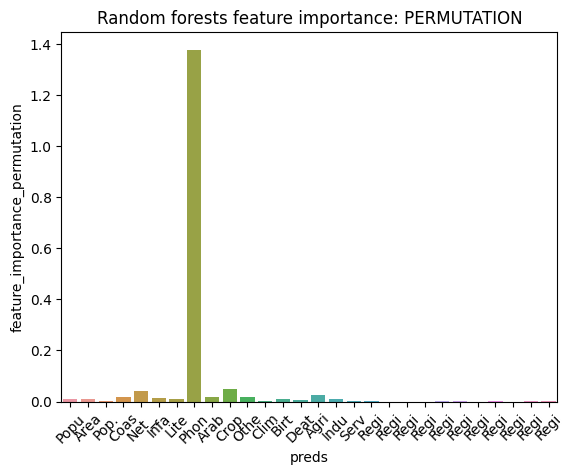

In [47]:
g = sns.barplot(rf_results_df, x = 'preds', y = 'feature_importance_permutation')
g.set_xticks(range(len(rf_results_df)))
g.set_xticklabels([pred[0:4] for pred in rf_results_df.preds],
                 rotation = 45)
g.set_title('Random forests feature importance: PERMUTATION')
plt.show()

Permutation importance paints a very similar picture. 

Based on random forests, subset logically would only include phones as a predictor

## 2.2: XGB 

In [48]:
import xgboost as xgb

# Fit the model
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X, y)

# Get feature importances
xgb_results_df = pd.DataFrame({'preds': xgb_reg.feature_names_in_,
                              'feature_importance' : xgb_reg.feature_importances_})

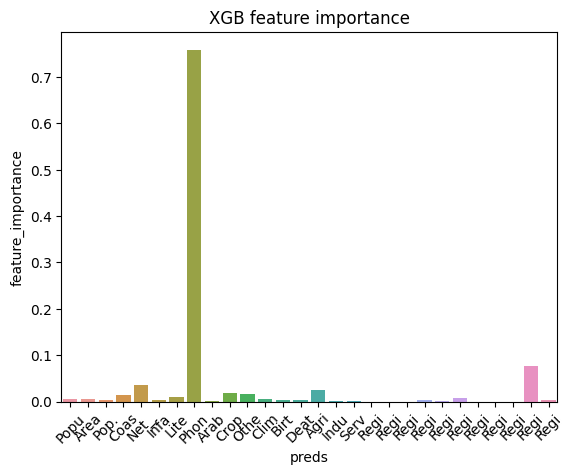

In [49]:
g = sns.barplot(xgb_results_df, x = 'preds', y = 'feature_importance')
g.set_xticks(range(len(rf_results_df)))
g.set_xticklabels([pred[0:4] for pred in rf_results_df.preds],
                 rotation = 45)
g.set_title('XGB feature importance')
plt.show()

There is one region that seems to be important in determining GDP per capita, we take a closer look

In [50]:
regions_only = xgb_results_df[xgb_results_df.preds.str.startswith('Region')].sort_values('feature_importance', ascending = False)

In [51]:
xgb_results_df[xgb_results_df.preds.str.startswith('Region')].sort_values('feature_importance', ascending = False)

,preds,feature_importance
26,Region_SUB-SAHARAN AFRICA,7.690954e-02
22,Region_NEAR EAST,6.687871e-03
27,Region_WESTERN EUROPE,3.651240e-03
20,Region_EASTERN EUROPE,2.428021e-03
21,Region_LATIN AMER. & CARIB,6.735720e-05
24,Region_NORTHERN AMERICA,1.626465e-05
23,Region_NORTHERN AFRICA,1.160199e-05
17,Region_ASIA (EX. NEAR EAST),2.223683e-06
19,Region_C.W. OF IND. STATES,9.755749e-09
18,Region_BALTICS,0.000000e+00


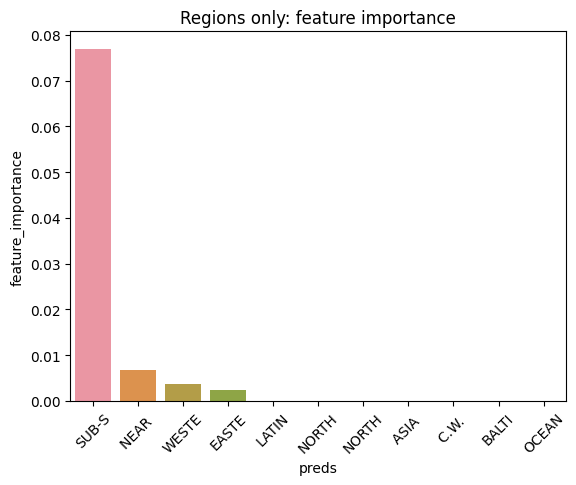

In [52]:
g = sns.barplot(data = regions_only, x = 'preds', y= 'feature_importance')
g.set_xticks(range(len(regions_only)))
g.set_xticklabels([pred[7:12] for pred in regions_only.preds],
                 rotation = 45)
g.set_title('Regions only: feature importance')
plt.show()

# Method 4: Embedded methods

We have already used Lasso in a previous exercise, so we will opt for the ElasticNet in this case, which utilises both L1 and L2 norm in regularising the parameters. The new regularisation parameter alpha controls the balance between L1 and L2 regularisation, where the new penalty is a weighted sum of both the L1 and L2 norms. 

ElasticNet is useful when there are **correlated predictors** and will. According to [user balaks](http://https://stats.stackexchange.com/users/82506/balaks), 

> When you have highly-correlated variables, Ridge regression shrinks the two coefficients towards one another. Lasso is somewhat indifferent and generally picks one over the other. Depending on the context, one does not know which variable gets picked. Elastic-net is a compromise between the two that attempts to shrink and do a sparse selection simultaneously.

Hence ElasticNet might allow us to group together multiple correlated features and assign them similar coefficients, instead of simply picking one of the features from the group, which Lasso achieves. 

In this case, choosing alpha $\alpha$ is very important in attaining the right amount of regularisation. Hence we conduct hyperparameter tuning

In [53]:
## Split data into train and validation for cross validation
from sklearn.model_selection import train_test_split

## Split with 15% test/val size
X_train, y_train, X_val, y_val = train_test_split(X, y, test_size = 0.15)

## Create the model and param grid 
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [54]:
## Instantiate empty model
elasticnet_model = ElasticNet()

## Make param grid 
param_grid = {'alpha': [0.01,0.1,1,10], ## controls overall penalty
             'l1_ratio': [0.1,0.4,0.7]} ## controls mix of l1 and l2 -- between 0 and 1

In [55]:
gs = GridSearchCV(estimator = elasticnet_model,
                 param_grid = param_grid, 
                 cv = 4)

gs.fit(X, y)

GridSearchCV(cv=4, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 1, 10],
                         'l1_ratio': [0.1, 0.4, 0.7]})

In [56]:
gs.best_params_

{'alpha': 0.1, 'l1_ratio': 0.7}

In [57]:
## Get best model
best_elasticnet = gs.best_estimator_

## get parameters 
best_elasticnet.get_params()
best_elasticnet.coef_

## Form df 
elasticnet_results = pd.DataFrame({'preds': best_elasticnet.feature_names_in_,
                                  'coeff':best_elasticnet.coef_ })

## Print
elasticnet_results.sort_values('coeff')

,preds,coeff
19,Region_C.W. OF IND. STATES,-2655.121968
21,Region_LATIN AMER. & CARIB,-1968.410834
20,Region_EASTERN EUROPE,-1496.640174
18,Region_BALTICS,-401.629969
22,Region_NEAR EAST,-100.758462
23,Region_NORTHERN AFRICA,-56.141391
11,Climate,-11.995334
14,Agriculture,-5.558570
9,Crops,-0.456345
13,Deathrate,-0.398601


Let us apply a thresholding to the absolute values 

In [58]:
elasticnet_results['abs coeff'] = np.abs(elasticnet_results.coeff)

## print
elasticnet_results.sort_values('abs coeff', ascending = False)

,preds,coeff,abs coeff
27,Region_WESTERN EUROPE,4378.782386,4378.782386
19,Region_C.W. OF IND. STATES,-2655.121968,2655.121968
21,Region_LATIN AMER. & CARIB,-1968.410834,1968.410834
20,Region_EASTERN EUROPE,-1496.640174,1496.640174
24,Region_NORTHERN AMERICA,1099.016534,1099.016534
25,Region_OCEANIA,750.036164,750.036164
18,Region_BALTICS,-401.629969,401.629969
17,Region_ASIA (EX. NEAR EAST),332.415904,332.415904
26,Region_SUB-SAHARAN AFRICA,120.785143,120.785143
22,Region_NEAR EAST,-100.758462,100.758462


### threshold = 1

In [59]:
elasticnet_results[elasticnet_results['abs coeff']> 1]

,preds,coeff,abs coeff
4,Net_migration,3.330507,3.330507
6,Literacy,4.892002,4.892002
7,Phones,2.707792,2.707792
11,Climate,-11.995334,11.995334
14,Agriculture,-5.558570,5.558570
15,Industry,2.817401,2.817401
16,Service,2.427137,2.427137
17,Region_ASIA (EX. NEAR EAST),332.415904,332.415904
18,Region_BALTICS,-401.629969,401.629969
19,Region_C.W. OF IND. STATES,-2655.121968,2655.121968


### threshold  = 5

In [60]:
elasticnet_results[elasticnet_results['abs coeff']> 5]

elasticnet_results[elasticnet_results['abs coeff']> 5].preds.to_list()

['Climate',
 'Agriculture',
 'Region_ASIA (EX. NEAR EAST)',
 'Region_BALTICS',
 'Region_C.W. OF IND. STATES',
 'Region_EASTERN EUROPE',
 'Region_LATIN AMER. & CARIB',
 'Region_NEAR EAST',
 'Region_NORTHERN AFRICA',
 'Region_NORTHERN AMERICA',
 'Region_OCEANIA',
 'Region_SUB-SAHARAN AFRICA',
 'Region_WESTERN EUROPE']

# Comparing all feature selections

Finally, before we compare all different methods, we redo the filter method but this time with the dummy variable encoding for the categorical regions that we had left out before. 

In [61]:
more_than_thresh = np.abs(countries_preprocessed.corr()['GDP'])  > 0.2
countries_preprocessed.corr()['GDP'][more_than_thresh].index

Index(['Net_migration', 'Infant_mortality', 'GDP', 'Literacy', 'Phones',
       'Birthrate', 'Agriculture', 'Service', 'Region_NORTHERN AMERICA',
       'Region_SUB-SAHARAN AFRICA', 'Region_WESTERN EUROPE'],
      dtype='object')

## 1: Correlation metrics favour: 
'Net_migration', 'Infant_mortality', 'Literacy', 'Phones',
       'Birthrate', 'Agriculture', 'Service', 'Region_NORTHERN AMERICA',
       'Region_SUB-SAHARAN AFRICA', 'Region_WESTERN EUROPE'
 
 ## 2: Bidirectional method favour:
'Area',
 'Net_migration',
 'Literacy',
 'Phones',
 'Crops',
 'Other',
 'Deathrate',
 'Agriculture',
 'Service',
 'Region_C.W. OF IND. STATES',
 'Region_EASTERN EUROPE',
 'Region_LATIN AMER. & CARIB',
 'Region_WESTERN EUROPE'
 
 ## 3: Feature importance models (tree based) favour:
 'Phones'
 
 ## 4: Embedded (ElasticNet) favour:
 'Climate',
 'Agriculture',
 'Region_ASIA (EX. NEAR EAST)',
 'Region_BALTICS',
 'Region_C.W. OF IND. STATES',
 'Region_EASTERN EUROPE',
 'Region_LATIN AMER. & CARIB',
 'Region_NEAR EAST',
 'Region_NORTHERN AFRICA',
 'Region_NORTHERN AMERICA',
 'Region_OCEANIA',
 'Region_SUB-SAHARAN AFRICA',
 'Region_WESTERN EUROPE'
 

## Create a summary data frame to see which features selected (True/False)

In [62]:
filter_subset = list(['Net_migration', 'Infant_mortality', 'Literacy', 'Phones', 'Birthrate', 'Agriculture', 'Service', 'Region_NORTHERN AMERICA', 'Region_SUB-SAHARAN AFRICA', 'Region_WESTERN EUROPE'])
bidirectional_subset = list(['Area', 'Net_migration', 'Literacy', 'Phones', 'Crops', 'Other', 'Deathrate', 'Agriculture', 'Service', 'Region_C.W. OF IND. STATES', 'Region_EASTERN EUROPE', 'Region_LATIN AMER. & CARIB', 'Region_WESTERN EUROPE'])
feature_imp_subset = ['Phones']
enet_subset = ['Climate', 'Agriculture', 'Region_ASIA (EX. NEAR EAST)', 'Region_BALTICS', 'Region_C.W. OF IND. STATES', 'Region_EASTERN EUROPE', 'Region_LATIN AMER. & CARIB', 'Region_NEAR EAST', 'Region_NORTHERN AFRICA', 'Region_NORTHERN AMERICA', 'Region_OCEANIA', 'Region_SUB-SAHARAN AFRICA', 'Region_WESTERN EUROPE']


In [63]:
all_preds = countries_preprocessed.columns
df = pd.DataFrame(index =  all_preds)
## print
df['filter method'] = df.index.isin(filter_subset)
df['bidirect method'] = df.index.isin(bidirectional_subset)
df['feature import method'] = df.index.isin(feature_imp_subset)
df['elasticnet method'] = df.index.isin(enet_subset)

In [64]:
df.sort_values(['filter method', 'bidirect method', 'feature import method',
       'elasticnet method'], ascending = False)

,filter method,bidirect method,feature import method,elasticnet method
Phones,True,True,True,False
Agriculture,True,True,False,True
Region_WESTERN EUROPE,True,True,False,True
Net_migration,True,True,False,False
Literacy,True,True,False,False
Service,True,True,False,False
Region_NORTHERN AMERICA,True,False,False,True
Region_SUB-SAHARAN AFRICA,True,False,False,True
Infant_mortality,True,False,False,False
Birthrate,True,False,False,False


## Visualise the feature selection per method 

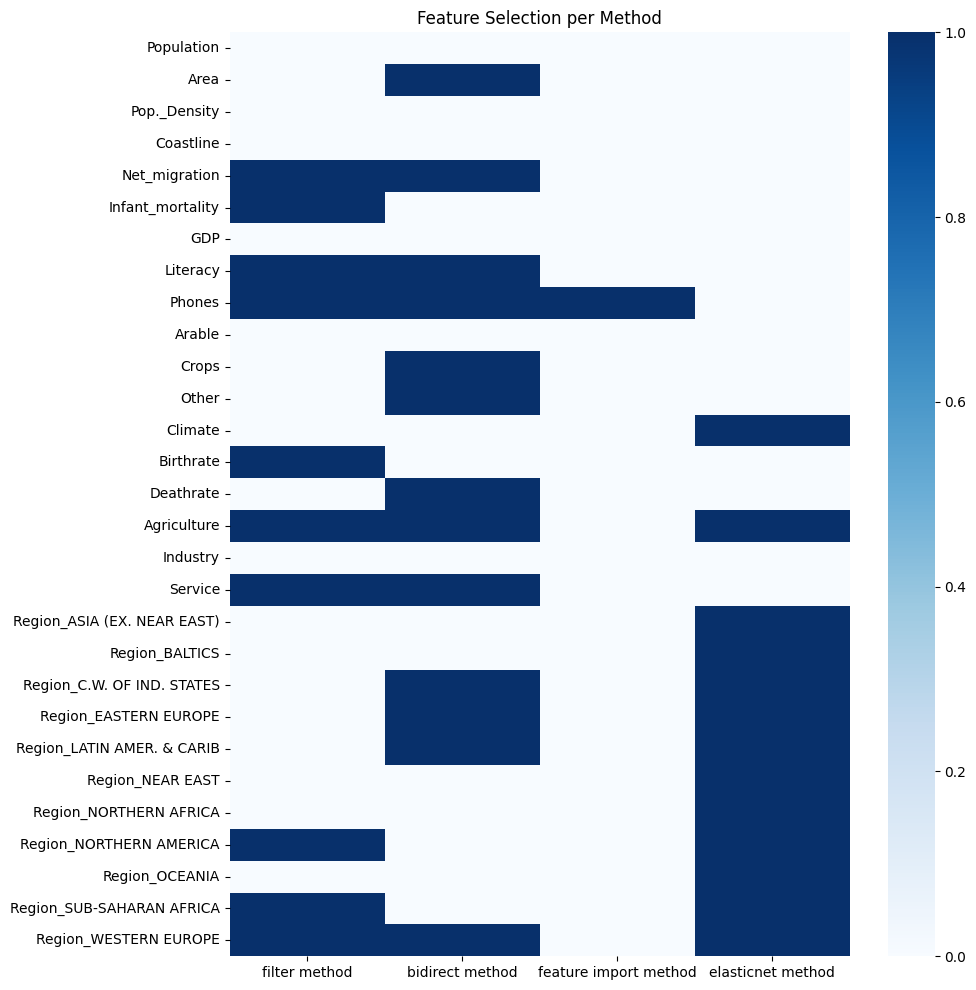

In [89]:
plt.figure(figsize = (10,12))
g = sns.heatmap(df, cmap='Blues', cbar=True)
g.set_title('Feature Selection per Method')
g.set_yticks([x +0.5 for x in range(len(df.index))])## a little more troublesome to add
g.set_yticklabels(df.index, rotation=0)  # Set rotation to 0 for better readability
plt.show()

## Overlaps 


In [72]:
## Linear methods 
print('Similarity between linear methods')
print(len(set(filter_subset).intersection(set(bidirectional_subset))))
print(len(set(filter_subset).intersection(set(enet_subset))))
print(len(set(enet_subset).intersection(set(bidirectional_subset))))

## Tree vs rest 
print('Similarity between tree based and the linear methods')
print(len(set(feature_imp_subset).intersection(set(bidirectional_subset))))
print(len(set(feature_imp_subset).intersection(set(enet_subset))))
print(len(set(feature_imp_subset).intersection(set(filter_subset))))


Similarity between linear methods
6
4
5
Similarity between tree based and the linear methods
1
0
1


## Summary

From both the heatmap and the number of common features between the different methods, we can easily see that the **bidirectional method is most similar to the filter method** when looking at non-region columns, but for region columns, they have selected different dummy variables (except for Western Europe). 

We can also immediately see how **elastic net** stands out from the rest, in that it choses **all region columns** (while the other methods only selected a few, or none), agriculture (chosen by the rest) and climate (**chosen by none of other methods**)

In [67]:
df.apply(sum)

filter method            10
bidirect method          13
feature import method     1
elasticnet method        13
dtype: int64

In [68]:
df.apply(sum, axis = 1).sort_values()

Population                     0
Pop._Density                   0
Coastline                      0
GDP                            0
Arable                         0
Industry                       0
Region_OCEANIA                 1
Region_NORTHERN AFRICA         1
Region_NEAR EAST               1
Region_BALTICS                 1
Region_ASIA (EX. NEAR EAST)    1
Birthrate                      1
Deathrate                      1
Other                          1
Crops                          1
Infant_mortality               1
Area                           1
Climate                        1
Region_SUB-SAHARAN AFRICA      2
Service                        2
Literacy                       2
Region_C.W. OF IND. STATES     2
Region_EASTERN EUROPE          2
Region_LATIN AMER. & CARIB     2
Net_migration                  2
Region_NORTHERN AMERICA        2
Agriculture                    3
Phones                         3
Region_WESTERN EUROPE          3
dtype: int64

## Summary

* Number selected: Feature importance has the least (only 1), while bidirectional method and elasticnet give the most (13). Filter method settles in between at 10. 

* Variables excluded the most: Population, Pop Density, Coastline, Arable, Industry.

    * Most Region dummies are also seldom selected, especially since they each capture a bit of information (for only a specific region)
    * Birth and deathrates, infant mortality are surprisingly only selected once as well 
    
* Variables included the most: Dummy for Western Europe (likley due to high GDP per capita), Phones, Agriculture
